In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0, DenseNet201
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import psutil

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
labels = ['Early_Blight','Healthy','Late_Blight']

In [4]:
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/kaggle/input/balanced-data/balanced_data','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/balanced-data/balanced_data','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/balanced-data/balanced_data','Validation',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 163/163 [00:01<00:00, 161.32it/s]


In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4398, 224, 224, 3)
(4398,)
(486, 224, 224, 3)
(486,)


In [6]:
print(np.unique(y_test))
print(np.unique(y_train))

['Early_Blight' 'Healthy' 'Late_Blight']
['Early_Blight' 'Healthy' 'Late_Blight']


In [7]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [8]:
all_model = pd.DataFrame(columns=['Model', 'Accuracy (Train)', 'Precision (Train)', 'Recall (Train)', 'F1 Score (Train)', 'Accuracy (Test)', 'Precision (Test)', 'Recall (Test)', 'F1 Score (Test)', 'Training Time (s)', 'Testing Time (s)','Memory (MB)'])

In [9]:
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time (s),Testing Time (s),Memory (MB)


**Feature Extraction from MobileNetV3Large**

In [10]:
# Define the base model for feature extraction
model = tf.keras.applications.MobileNetV3Large(
    include_top=False,  # Exclude fully connected layers
    weights="imagenet",  # Pretrained weights from ImageNet
    input_shape=(image_size, image_size, 3),  # Input image size
    pooling="avg"  # Global average pooling layer to get feature vector
)

# Freeze the base model to prevent updates during feature extraction
model.trainable = False


12683000/12683000 [==============================] - 0s 0us/step


In [11]:
# Use the base model to extract features
X_train = model.predict(X_train, batch_size=32, verbose=1)

138/138 [==============================] - 7s 21ms/step


In [12]:
# If labels are one-hot encoded, convert to class indices
if y_train.shape[-1] > 1:
    y_train = np.argmax(y_train, axis=1)

In [13]:
# X_train now contains the extracted features, and y_train contains the labels
print("Extracted features shape:", X_train.shape)
print("Labels shape:", y_train.shape)

Extracted features shape: (4398, 960)
Labels shape: (4398,)


In [14]:
# Use the base model to extract features from test data
X_test = model.predict(X_test, batch_size=32, verbose=1)

16/16 [==============================] - 1s 42ms/step


In [15]:
# If labels are one-hot encoded, convert to class indices
if y_test.shape[-1] > 1:
    y_test = np.argmax(y_test, axis=1)

In [16]:
# X_test now contains the extracted features, and y_test contains the labels
print("Extracted features shape:", X_test.shape)
print("Labels shape:", y_test.shape)

Extracted features shape: (486, 960)
Labels shape: (486,)


In [17]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Define the Level 0 classifiers
level_0_estimators = [
    ('svm', SVC(kernel='rbf',C=1.0,gamma='scale',decision_function_shape='ovr')),
    ('knn', KNeighborsClassifier()),
    ('logistic', LogisticRegression(multi_class='multinomial',solver='lbfgs',C=1.0,max_iter=1000,random_state=42 )),
    ('mlp', MLPClassifier(random_state=42)),
    ('decision_tree', DecisionTreeClassifier(criterion='gini',max_depth=20,min_samples_split=5,min_samples_leaf=3,max_features='sqrt',random_state=42)),
    ('naive_bayes', GaussianNB(var_smoothing=1e-8))
]

# Define the Level 1 classifier (meta-classifier)
level_1_meta_classifier = XGBClassifier(
    n_estimators=300,            
    learning_rate=0.05,          
    max_depth=6,                 
    objective='multi:softprob',  
    num_class=3,                
    subsample=0.8,               
    colsample_bytree=0.8,        
    gamma=1,                     
    min_child_weight=3,          
    random_state=42              
)

# Create the Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=level_0_estimators,
    final_estimator=level_1_meta_classifier,
    cv=5
)

In [18]:
import time

# Start timer
start_time = time.time()

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Measure training time
training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Evaluate memory usage (optional, requires `psutil` library)
import psutil
memory_usage = psutil.Process().memory_info().rss / 1024 / 1024
print(f"Memory Usage: {memory_usage:.2f} MB")

Training Time: 72.60 seconds
Memory Usage: 3544.48 MB


In [19]:
# make predictions on the test data
start_time = time.time()
y_pred = stacking_clf.predict(X_test)
testing_time = time.time() - start_time

Confusion matrix, without normalization


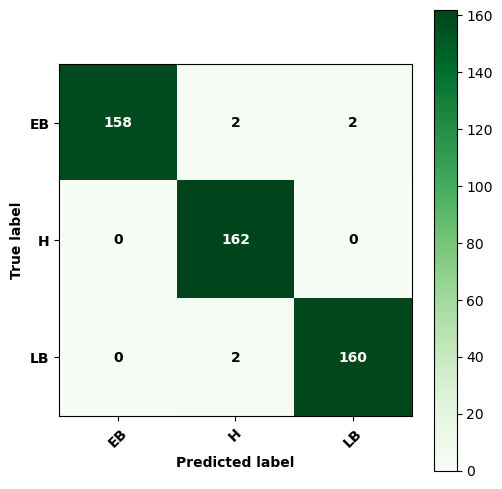

In [20]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontweight='bold')
    plt.yticks(tick_marks, classes, fontweight='bold')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center", fontweight='bold',
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontweight='bold')
    plt.xlabel('Predicted label',fontweight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['EB','H','LB']
                      )
plt.show()

In [21]:
y_pred.shape

(486,)

In [22]:
accuracy_test = accuracy_score(y_test, y_pred)*100
precision_test = precision_score(y_test, y_pred, average='macro')*100
recall_test = recall_score(y_test, y_pred, average='macro')*100
f1_test = f1_score(y_test, y_pred, average='macro')*100

print("Accuracy (Test): {:.4f}".format(accuracy_test))
print("Precision (Test): {:.4f}".format(precision_test))
print("Recall (Test): {:.4f}".format(recall_test))
print("F1 score (Test): {:.4f}".format(f1_test))

Accuracy (Test): 98.7654
Precision (Test): 98.7853
Recall (Test): 98.7654
F1 score (Test): 98.7653


In [23]:
# make predictions on the train data
y_pred = stacking_clf.predict(X_train)

Confusion matrix, without normalization


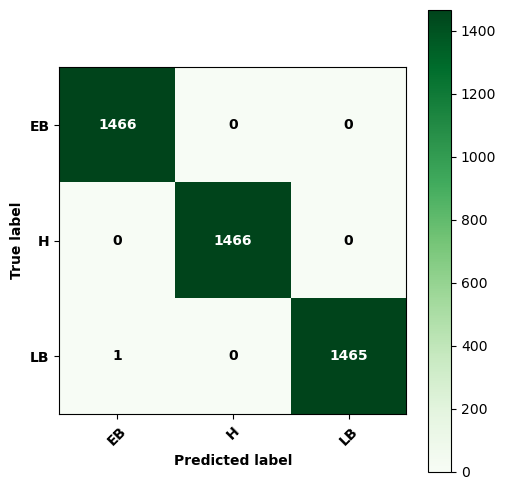

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontweight='bold')
    plt.yticks(tick_marks, classes, fontweight='bold')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center", fontweight='bold',
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontweight='bold')
    plt.xlabel('Predicted label',fontweight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['EB','H','LB']
                      )
plt.show()

In [25]:
accuracy_train = accuracy_score(y_train, y_pred)*100
precision_train = precision_score(y_train, y_pred, average='macro')*100
recall_train = recall_score(y_train, y_pred, average='macro')*100
f1_train = f1_score(y_train, y_pred, average='macro')*100

print("Accuracy (Train): {:.4f}".format(accuracy_train))
print("Precision (Train): {:.4f}".format(precision_train))
print("Recall (Train): {:.4f}".format(recall_train))
print("F1 score (Train): {:.4f}".format(f1_train))

Accuracy (Train): 99.9773
Precision (Train): 99.9773
Recall (Train): 99.9773
F1 score (Train): 99.9773


In [26]:
model_name='MobileNetV3Large-XGB'
all_model.loc[len(all_model)] = [model_name, accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test, training_time, testing_time, memory_usage]

In [27]:
all_model

,Model,Accuracy (Train),Precision (Train),Recall (Train),F1 Score (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 Score (Test),Training Time (s),Testing Time (s),Memory (MB)
0,MobileNetV3Large-XGB,99.977262,99.977278,99.977262,99.977262,98.765432,98.785265,98.765432,98.765307,72.596139,0.458252,3544.480469
